# Import Python Libraries

In [1]:
# import libraries
import pandas as pd
import numpy as np
import datetime
import re
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.cluster import KMeans
import seaborn as sns
from matplotlib.ticker import FuncFormatter

# Transform Raw Data into Working Dataset

In [2]:
# extract raw data from pickle file
df_raw = pd.read_pickle('/Users/barkleyjenny/Desktop/programbuild/kroger_2023/kroger_data_2023-09-06 10 28 15.113265.pkl')

In [3]:
# drop items with no reg_price value
df = df_raw.dropna(axis = 0, subset = ['reg_price'])
df = df.reset_index(drop = True)

## Standardize Fill Weights

In [4]:
# standardize net fill values

# function to extract raw net fill data
def extract_raw_net_fill(size):
    multipack_pattern = r'\d+.?ct.?/'
    hfexcept_pattern = r'(\d+)\s*-\s*([\d.]+)'
    fill_pattern = r'\d+\.\d+|\.?\d+'
    if '1/2 gal'in size:
        return 0.5
    elif re.search(multipack_pattern, size):
        case = float(re.findall(fill_pattern, size)[0])
        fill = float(re.findall(fill_pattern, size)[-1])
        return round(case * fill, 4)
    elif re.search(hfexcept_pattern, size):
        case2 = float(re.findall(fill_pattern, size)[0])
        fill2 = float(re.findall(fill_pattern, size)[-1])
        return round(case2 * fill2, 4)
    elif re.match(fill_pattern, size):
        match = re.findall(fill_pattern, size)
        return match[0]
    else:
        return 1    

# function to convert raw measures and units to standardized forms
def standardize_measures(row):
    if row['raw_uom'] in dict_measures:
        conversion_factor = dict_measures[row['raw_uom']]
        return round(row['raw_net_fill'] / conversion_factor,4)
    else:
        return row['raw_net_fill']
    
def standardize_units(row):
    if row['raw_uom'] in dict_units:
        new_uom = dict_units[row['raw_uom']]
        return new_uom
    else: 
        return row['raw_uom']
    
# dictionary to convert raw fill measures to standardized lb and gal measures
# (note ratio for non-measures like 'ct' or None are set to 1 to avoide div 0)
dict_measures = {
    'fl oz': 128,
    'oz': 16,
    'ml': 3785,
    'ml / pack': 3785,
    'ct':1,
    None:1,
    'gal':1,
    'liter':3.785,
    'milliliter':3785,
    'lb':1,
    'lbs':1,
    'qt':4,
    'pt':8,
    'pint':8,
    'pound':1,
    'ounce': 16,
    'g':453,
    'oz.': 16,
    'pounds': 1,
    'fluid ounce':128,
    'oz each':16,
    'fz each':128
           }

# dictionary to convert raw net fill units to standardized lb and gal units
dict_units = {
    'fl oz': 'gal',
    'oz': 'lb',
    'ml': 'gal',
    'ct':'ct',
    'liter':'gal',
    'milliliter':'gal',
    'fluid ounce':'gal',
    None:None,
    'gal':'gal',
    'lb':'lb',
    'lbs':'lb',
    'qt':'gal',
    'pt':'gal',
    'pint':'gal',
    'pound': 'lb',
    'ounce': 'lb',
    'g':'lb',
    'oz.':'lb',
    'pounds':'lb',
    'oz each':'lb',
    'fz each': 'gal'
            }

# apply function to extract raw net fill measurements
df['raw_net_fill'] = df['size'].apply(extract_raw_net_fill).astype(float)

# regex to extract raw units of measure
df['raw_uom'] = df['size'].str.extract(r'([\d.]+)(?![\d\D]*\d) (.*)', expand = False)[1]

df['net_fill'] = df.apply(standardize_measures, axis = 1)
df['uom'] = df.apply(standardize_units, axis = 1)

## Add Department Tags

In [5]:
# add standardize department tags, add department column

# apply string comprehension and a lambda function to extract the best department tag
df.department = df.department.apply(lambda department: department[0] if department[0] != 'Natural & Organic' else department[-1])

## Parse Organic Status

In [6]:
# create a column to signify whether a product is organic or not
# USDA organic labelling standards state that only organic certified products may use the word 'organic' in the product name
df['organic_status'] = df['name'].apply(lambda name: 'organic' if re.match(r'.*organic.*', name, flags = re.IGNORECASE) else 'conventional')

## Parse Common Names

In [7]:
# simplify product names to a 'common name' to be used for comparison between convetional and organic

# formulas for removing unwanted characters from item names
# remove brand
def remove_brand (row):
    if row['brand'] and row['brand'] in row['common_name']:
        return re.sub(row['brand'], '',row['common_name'], flags = re.IGNORECASE)
    else:
        return row['common_name']

# set name to lowercase
def lower_case (name):
    return name.lower()
    
# remove keywords and product formats
def remove_words (name):
    remove = '|'.join(keywords + formats)
    if remove:
        return re.sub(remove,'',name, flags = re.IGNORECASE)
    else:
        return name

def replace_words (name):
    for key, value in dict_words.items():
        name =  re.sub(key, value, name, flags = re.IGNORECASE)
    return name

# replace certain symbols w/ spaces
def replace_space (name):    
    replace = '|'.join(symbols)
    if replace:
        return re.sub(replace, ' ',name, flags = re.IGNORECASE)
    else:
        return name

# remove symbols
def remove_symbols (name):    
    remove = '|'.join(symbols)
    if remove:
        return re.sub(remove, '',name, flags = re.IGNORECASE)
    else:
        return name
    
# # remove double spaces, leading and trailing spaces
def trim_spaces (name):
    
    remove = '|'.join(spaces)
    if remove:
        return re.sub(remove, '',name, flags = re.IGNORECASE)
    else:
        return name


    
ls_name_functions = [lower_case, remove_words, replace_words, remove_symbols, trim_spaces]


# lists of strings used for cleaning product names
keywords = [
    r'grab \'n go', r'Grab \'N Go', 'large', 'snacking','snacker','snacks?',
    'bowl', 'organics?', 'small', 'Tray', 'Nickelodeon Paw Patrol',
     'SpongeBob Squarepants', 'Disney Foodle', 'BIG Deal!',
    'Pro2Snax', r'\bFresh\b', 'Protein Plus Dutch', r'\bwith\b',
    'r\bpound\b', 'california', '100% juice', 'fruit juice',
    'mighty', 'chopped', r'in\s?\d+\s?lb', 'golden rows', 
    'probiotic', 'fireworks?', r'\bpower\b', r'\bcrunchy?\b',
    'romain calm', r'\bwild', r'\bchild\b', r'natural[(s)(ly)]?', r'delights?',
    r'simpl[ey]', r'\bozs?\b', r'\bbaked?\b', 'this dip is nuts!',
    '100%', 'romaine calm', 'protein', 'bolthouse farms', 
    'bolts', 'immunity', r'\bonly\b', 'a dash of', r'\bbunch\b',
    'curly', r'Driscoll(\'s)?', 'limited', 'edition', 'sweetest', 'batch',
    'petite', 'soy free', r'\bripe\b', 'chunky', 'stir in', 'stixx',
    'premium', 'clamshell', 'sugar free', 'brand', 'fruit fusion', 
    r'\bsuper\b', 'naked juice', 'naturesweet', 'heavenly salad', 'xxl',
    r'\(4-5 Tomatoes per Bunch\)', 'squeeze', r'\bmade\b',
    'medium', 'ruby rows', '50/50', 'hiiros', r'\bslicing\b',
    'single serve', 'on the go', 'perfectly', r'plant.?based', 'spicy',
    r'queso.?style', 'deluxe', 'grab & run', 'biologique', 'ultimate', 
    'immune', 'super', 'bolthouse farms', r'\'s', '/pink', 'ruby', 
    'all stars', r'annie.s', 'artisinal', 'beanvivo', 'bernie o', 
    'cheesy', 'creamy', 'light in sodium', 'soups', 'fire roasted',
    'hearty', 'rustic', 'low sodium', 'farm friends', r'\breal\b', r'\baged?\b',
    'goya', 'muir glen', 'no salt added', r'\bnsa\b',
    'fat free refried', 'no sugar added', r'\bseasoned\b', r'\bpure\b', 'crispy',
    r'\bjar\b', 'take root', 'bunnies', 'back to nature', r'squares?',
    'stone.?ground', 'GoGo SqueeZ® Organic Happy ImmuneZ', 'sunshine',
    r'\bthin\b', 'lightly', 'vitality', r'\bmary\b', r'originale?', 'classic',
    'sun ripened', 'unsulfured', 'grain.?free', 'keto', 'minis?', 'cling', 'truth',
    'party size', 'non gmo', 'just nuts', r'\bsticks?\b',
    'free.?range', 'peeled and','ready to eat', 
    r'tubes?', r'\bkids?\b', 'yo baby', 'stonyfield', 'good2grow 8oz',
    'oatsome barista', r'\btub\b', 'unsweetened', r'dairy.?free',
    'forager project', 'singles', r'omega.?3', 'dha', r'grass.?fed',
    'creamery', 'reduced fat', 'finely', 'cage.?free', r'\bvery\b', 
    r'\bplain\b', 'good2grow', r'\d+(\.\d+)?.?oz', r'ultra.?pasturized', 'old school',
    r'amy.?s', 'cascadian farm', 'world\'s best', 'perdue', r'\bsmart\b',
    'pitaway foods', 'bite size', 'superfruit', 'freshly', 'supersweet', 
    'baja', 'lundberg family farms', r'old.?fashioned', '90 second',
    r'Frontier.? Natural Products Co.?op', 'gourmet', 'ground', 'refined', 
    '22 ounces', 'unbleached white', 'unbleached', 'amish country',
    'clif zbar iced', 'defense', r'\bplus\b', r'Qi.?a', 'super.?foods?', 'superseeds',
    'amber color', 'dark color', 'robust', r'home.?style', '8 pack',
    'variety', 'ketola', 'love', 'double', 'nature.?s path', 'no added sugar',
    'rockin.? grains english muffins', 'sesame street', 'gerber',
    'wonderfoods', 'harvest', 'jammy sammy', r'lil..crunchies', 'mucho',
    'my veggies', 'morning', 'once upon a farm', 'plant tastic', 
    'Plum® Organics', 'sprout ourganic crinklez', 'teethers', 'toddler',
    'wholesome breakfast', 'dinner', 'fiber & protein', 'grain & grow', 
    'mama', 'numi', 'gunpowder', 'orange cold-pressed', r'cold.pressed',
    'r\.w\.', 'usda', 'riot', 'sensible sippers', 'smooth move', 'synergy', 
    r'\btart\b', r'\bzen\b', r'low.?fat',r'\braw\b', 'regenerative', 'raw & un.?filtered',
    'pasture-raised', r'vitamin.?d', '\bAll\b', 'Fresh', 'Family', 'Roaster',
    'Air.?chilled', r'\byoung\b', r'\bs\b', r'\bsilken\b', 'blue box', 
    r'non.?gmo', 'kosher', 'certified', 'italian', 'vegan', 'verified',
    'Traditional', r'\bno.stir\b', 'bellucci', r'(extra.)?virgin', r'\brich(.taste)?\b',
    r'\bsmooth\b', 'mediterranean', r'expeller.pressed', 'liquid', 'unrefined',
    r'Nestle®? Toll House®?', 'allergy.free', 'wholesome', 'less sodium',
    'lite', 'Hunt’s® Best Ever' , 'Reduced Sugar & Sodium', r'\d+% lower sodium',
    '\bfrontier\b', 'movie theater', r'\d+% fat free', 'buttery explosion','extra butter',
    r'supreme(ly)?', 'granulated', 'no pulp', 'with pulp', 'with calcium', 'all.?natural',
    'pulp free', 'calcium', 'meal.ready sides', 'steam.fresh', 'haagen dazs', 'madagascar',
    '\bgrand\b', 'vivdly', 'artisan', 'No Artificial Growth Hormones', 'and unfiltered']



formats = [
    r'\bbags?\b', r'\bkit\b', r'\bpacks?\b', r'\beach\b', r'\bpouch(es)?\b',
    r'\bbottles?\b', r'\bcan\b', r'\(\d+ pack\)', r'\bbulbs\b', 'case sale',
    r'multi.?pack', 'family size']

symbols = [r'\b[^a-zA-Z0-9\s]\b', '-', '\s–\s', '™', '®', '\+', 'r’^\band\b']

spaces = [r'^\s+',r'\s+$']

dict_words = {'canned soup':'soup', 'cucumbers':'cucumber', 
              '&':'and', r'\s{2,}':' ', 'low fat minestrone':'minestrone',
             'low fat split pea':'split pea', 'fat.?free milk':'skim milk',
             'vanilla bean':'vanilla', 'dry green lentils':'green lentils',
             'long english':'english', 'blue agave light golden syrup':'agave syrup',
            r'\bn\b':'and', 'french vanilla':'vanilla', 
              'starwberry granola':'strawberry granola', 'all-purpose':'all purpose',
             '90% lean beef':'ground beef 90%', 'beef sirloin 90% lean':'ground beef 90%',
             'spaghetti pasta':'spaghetti', 'valencia orange':'valencia oranges',
             'zucchini squash':'zucchini', 'whole milk ricotta cheese': 'ricotta cheese',
             'Garbanzo Beans Chick-Peas':'garbanzo beans','chick peas garbanzos':'garbanzo beans',
             'peanut butter spread':'peanut butter', 'semi.sweet':'semisweet',
             'Tomato ketchup':'ketchup', 'french dijon':'dijon', 'butter popcorn':'popcorn',
             'butter microwave popcorn':'microwave popcorn', 'cane sugar':'sugar', 
             '^.+roast coffee':'roast coffee', r'(.+)?frozen pizzas?':'frozen pizza', 'and unfiltered honey':'honey'}

# add common name column
df['common_name'] = df['name']

# apply functions to remove nonessential information from the product name
df['common_name'] = df.apply(remove_brand, axis = 1)
for function in ls_name_functions:
    df['common_name'] = df['common_name'].apply(function)


<>:110: SyntaxWarning: invalid escape sequence '\.'
<>:131: SyntaxWarning: invalid escape sequence '\s'
<>:131: SyntaxWarning: invalid escape sequence '\+'
<>:110: SyntaxWarning: invalid escape sequence '\.'
<>:131: SyntaxWarning: invalid escape sequence '\s'
<>:131: SyntaxWarning: invalid escape sequence '\+'
/var/folders/kk/vvsk9nv52tx96gkssmn_4c240000gn/T/ipykernel_69502/587701850.py:110: SyntaxWarning: invalid escape sequence '\.'
  'r\.w\.', 'usda', 'riot', 'sensible sippers', 'smooth move', 'synergy',
/var/folders/kk/vvsk9nv52tx96gkssmn_4c240000gn/T/ipykernel_69502/587701850.py:131: SyntaxWarning: invalid escape sequence '\s'
  symbols = [r'\b[^a-zA-Z0-9\s]\b', '-', '\s–\s', '™', '®', '\+', 'r’^\band\b']
/var/folders/kk/vvsk9nv52tx96gkssmn_4c240000gn/T/ipykernel_69502/587701850.py:131: SyntaxWarning: invalid escape sequence '\+'
  symbols = [r'\b[^a-zA-Z0-9\s]\b', '-', '\s–\s', '™', '®', '\+', 'r’^\band\b']


## Calculate Price per lb or fl oz

In [8]:
# calculate a price / unit based on standard units
df['price_per_uom'] = round(df['reg_price'] / df['net_fill'], 2)

# create a column that compares an item's net fill to other items within its common_name group
df_ave_fill_by_item = df.groupby('common_name')['net_fill'].mean().reset_index()
df_ave_fill_by_item.rename(columns = {'common_name':'common_name', 'net_fill':'ave_net_fill_group'}, inplace = True)
df_std_fill_by_item = df.groupby('common_name')['net_fill'].std().reset_index()
df_std_fill_by_item.rename(columns = {'common_name':'common_name', 'net_fill':'std_net_fill_group'}, inplace = True)

df = df.merge(df_ave_fill_by_item, on = 'common_name', how = 'left')
df = df.merge(df_std_fill_by_item, on = 'common_name', how = 'left')

df['net_fill_comp'] = round(df.net_fill / df.ave_net_fill_group * 100)

# Create Item Match & Comparison Dataframe

## Create Lowest Cost Item Pairs

In [9]:
# Function to determine an item contains both organic & conventional variants
def check_org_status(group):
    return group['organic_status'].nunique() > 1

# remove variants with significant net fill bias
df_groups = df.loc[(df.net_fill_comp >= 20) & (df.net_fill_comp <= 180)]


# pass common name matches to check_org_status function
df_groups = df_groups.groupby(['common_name', 'uom']).filter(check_org_status)

#filter out all entires per group except the lowest cost variant
df_groups = df_groups.loc[df_groups.groupby(['common_name', 'organic_status'])['price_per_uom'].idxmin()].reset_index(drop=True)


# split into organic + conventional dataframes then merge into comparison frame
working_columns = ['common_name', 'name', 'brand', 'price_per_uom', 'net_fill', 'uom']
df_organic = df_groups.loc[df_groups.organic_status == 'organic']
df_organic = df_organic[working_columns]

df_conventional = df_groups.loc[df_groups.organic_status == 'conventional']
df_conventional = df_conventional[['department'] + working_columns]

df_compare = df_conventional.merge(df_organic, how = 'left', on = 'common_name', suffixes = ('_conventional','_organic'))

# add dollar difference, premium percent and net fill comp columns
df_compare['dollar_difference'] = round(df_compare['price_per_uom_organic'] - df_compare['price_per_uom_conventional'], 2)
df_compare['premium_percent'] = round(df_compare['dollar_difference'] / df_compare['price_per_uom_conventional'] * 100, 0)
df_compare['net_fill_comp_percent'] = round(df_compare['net_fill_organic'] / df_compare['net_fill_conventional'] * 100, 0)

## Segment Data by Quintile

In [10]:
# use quintiles to sesgment products by percent premium

df_compare['quintile'] = pd.qcut(df_compare.premium_percent, q = 5, labels = False)

# Analysis

## How many grocery items were we able to compare?

In [11]:
# How many grocery items were we able to compare?
raw_item_count = df.reg_price.count()
print( f'Products with complete pricing information pulled from the Kroger API: {raw_item_count}') 

df_organic_count = df.organic_status == 'organic'
organic_product_count = df_organic_count.sum()
print( f'Organic products included in data pull: {organic_product_count}') 

df_conventional_product_count = df.organic_status == 'conventional'
conventional_product_count = df_conventional_product_count.sum()
print( f'Conventional products included in data pull: {conventional_product_count}') 

matches_count = df_compare.common_name.count()
print( f'Number of organic and conventional item pairs used in the comparison: {matches_count}')


departments_count = df_compare.department.nunique()
print( f'The comparision included items from {departments_count} different departments.')

Products with complete pricing information pulled from the Kroger API: 11013
Organic products included in data pull: 1165
Conventional products included in data pull: 9848
Number of organic and conventional item pairs used in the comparison: 206
The comparision included items from 18 different departments.


## What was the median price premium for organic products?


In [12]:
median_percent_premium_full = df_compare.premium_percent.median()

print(f'The median price premium for organic was {median_percent_premium_full}%.')

The median price premium for organic was 44.0%.


## How do the median price premiums compare by category where we have a significant sampling?


## Summarize Premiums by Department

In [13]:
# group comparision dataframe by category and summarize

df_department_count = df_compare.groupby('department')['common_name'].count().reset_index().sort_values('common_name', ascending = False)
df_department_count.rename(columns = {'department':'department','common_name':'items_included'}, inplace = True)

df_department_ave = round(df_compare.groupby('department')['premium_percent'].mean(),0).reset_index()
df_department_ave.rename(columns = {'department':'department','premium_percent':'ave_premium_percent'}, inplace = True)

df_department_med = round(df_compare.groupby('department')['premium_percent'].median(),0).reset_index()
df_department_med.rename(columns = {'department':'department','premium_percent':'med_premium_percent'}, inplace = True)

# list of departments with 5 or more item pairs
ls_significant_departments = df_department_count[df_department_count['items_included'] >= 5].department.tolist()

df_compare['dept_median'] = df_compare.groupby('department')['premium_percent'].transform('median')

In [14]:
df_department_med.sort_values(by = 'med_premium_percent')

,department,med_premium_percent
0,Adult Beverage,-20.0
5,Breakfast,-8.0
9,Deli,4.0
11,Health,15.0
14,Natural & Organic,27.0
8,Dairy,36.0
16,Produce,40.0
1,Baby,42.0
6,Canned & Packaged,51.0
7,Condiment & Sauces,51.0


## Highlight Interesting Datapoints

In [15]:
def assign_highlight(row):
    if row['common_name'] in ls_complexity:
        return 'complexity'
    elif row['common_name'] in ls_valuedriver:
        return 'value'
    else:
        return 'no_highlight'  # or any other default value

ls_complexity = [
    'frozen peas and carrots', 
    'whole chicken', 
    'chocolate chip cookies', 
    'frozen pizza', 
    'light brown sugar', 
    'whole milk',
    'raspberry lemonade',
    'strawberry yogurt',
    'peanut butter'] 

ls_valuedriver = [
    'orange juice beverage', 	
    'orange juice pulp', 	
    'orange juice', 	
    'Yogurt', 
    'whole grain brown rice', 	
    'avocado oil', 	
    'whole wheat bread', 	
    'whole milk yogurt', 	
    'apple juice', 	
    'concord grape jelly', 	
    'ketchup', 	
    'dried cranberries', 	
    'garbanzo beans', 	
    'roasted and salted pistachios']	


# Apply the custom function to create the 'highlight' column
df_compare['highlight'] = df_compare.apply(assign_highlight, axis=1)

In [16]:
df_compare.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206 entries, 0 to 205
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   department                  206 non-null    object 
 1   common_name                 206 non-null    object 
 2   name_conventional           206 non-null    object 
 3   brand_conventional          163 non-null    object 
 4   price_per_uom_conventional  206 non-null    float64
 5   net_fill_conventional       206 non-null    float64
 6   uom_conventional            206 non-null    object 
 7   name_organic                206 non-null    object 
 8   brand_organic               169 non-null    object 
 9   price_per_uom_organic       206 non-null    float64
 10  net_fill_organic            206 non-null    float64
 11  uom_organic                 206 non-null    object 
 12  dollar_difference           206 non-null    float64
 13  premium_percent             206 non

# Data Visualization

## Global Style Code for Graphs & Charts

In [17]:
# Graph styling code

# fonts & font size
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=14)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=11)    # fontsize of the tick labels
plt.rc('ytick', labelsize=11)    # fontsize of the tick labels
plt.rc('legend', fontsize=11)    # legend fontsize
plt.rc('font', size=11)          # controls default text sizes

# color palette can be passed as a list of hex codes
custom_colors = ["#000000", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]

# Set all fonts to Roboto using rcParams
plt.rcParams["font.family"] = 'Roboto'

# set overall plot style, font size scaling factor, and color palette
sns.set(style="whitegrid", 
        font_scale=1.2, 
        palette=custom_colors 
       )

# add labels to a vertical bar chart
def datalabel_bar(ax, fontsize=12):
  rects = [rect for rect in ax.get_children() if isinstance(rect, mpl.patches.Rectangle)]
  
  for rect in rects:
    height = rect.get_height()
    if height > 0:
      ax.annotate(f"{height}", xy=(rect.get_x() + rect.get_width() / 2, height), 
        xytext=(0, 3), # 3 points offset 
        textcoords="offset points", ha="center", va="bottom", fontsize=fontsize)

# add labels to a horizontal bar chart
def datalabel_hbar(ax, fontsize=12):
  rects = [rect for rect in ax.get_children() if isinstance(rect, mpl.patches.Rectangle)]
  
  for rect in rects:
    width = rect.get_width()
    if width > 1:
      ax.annotate(f"{width:.0f}", xy=(width, rect.get_y() + rect.get_height() / 2),
        xytext=(5,-1), # 5 points offset
         textcoords="offset points", ha="left", va="center", fontsize=fontsize)

## Bar Chart: 5th Quintile Organic Premiums

/var/folders/kk/vvsk9nv52tx96gkssmn_4c240000gn/T/ipykernel_69502/1205026125.py:140: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


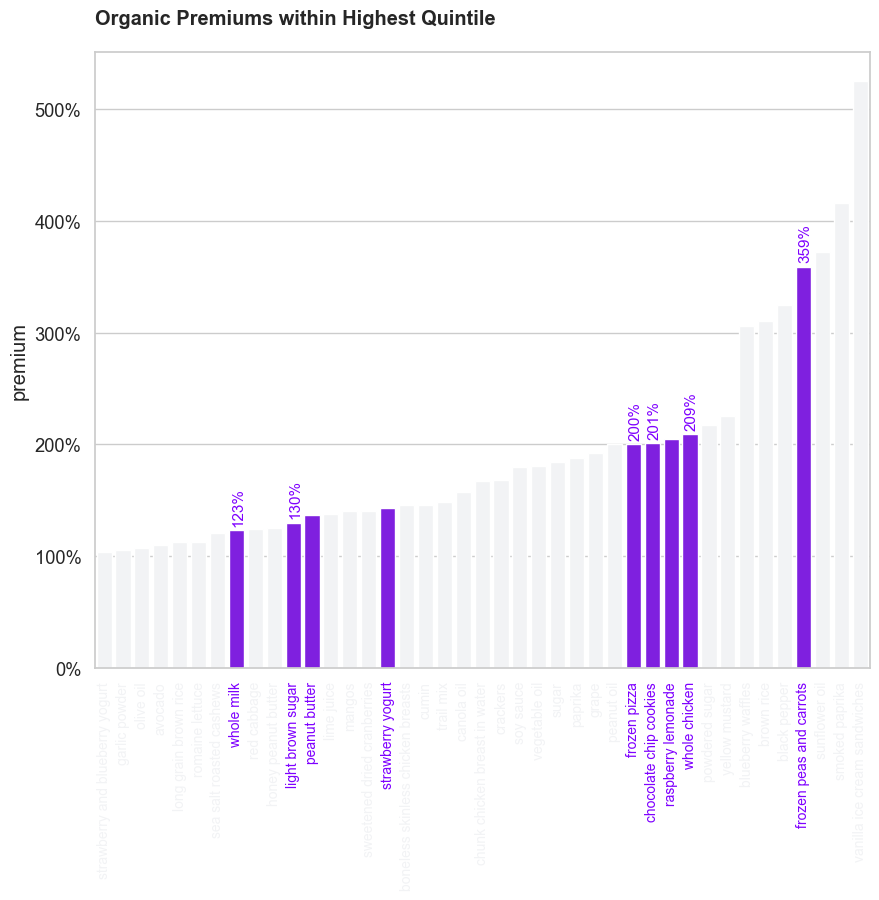

In [18]:
df_barplotq5 = df_compare[df_compare['quintile']==4].sort_values(by='premium_percent').reset_index(drop=True)
fig,ax = plt.subplots(figsize=(10,8))
g = sns.barplot(
    x = 'common_name',
    y = 'premium_percent',
    data = df_barplotq5,
    hue = 'highlight',
    palette = ['#F2F3F5', '#7F00FF'],
    legend = False
    )

# x-axis
# g.xaxis.set_ticklabels([])
g.set(xlabel='')

plt.xticks(rotation='vertical', fontsize = 10, ha='center', va='top')
# change x-axis tick label color based on condition
for tick in g.get_xticklabels():
    if tick.get_text() in ls_complexity:
        tick.set_color('#7F00FF')
    else:
        tick.set_color('#F2F3F5')


# y-axis
g.set(ylabel='premium')
# plt.tick_params(
#     bottom=True, 
#     color='black',
#     labelbottom=True, 
#     labelcolor= 'black')
# Add '%' symbols to x-axis labels
def percent_formatter(x, pos):
    return f'{x/100:.0%}'
plt.gca().yaxis.set_major_formatter(FuncFormatter(percent_formatter))

# gridlines

# datalabels
fontsize = 11
ax.annotate(
    f"{'123'}%", 
    xy=(7.1, 123), 
    xytext=(0, 3),  # 3 points offset
    textcoords="offset points", 
    color = '#7F00FF',
    ha="center", va="bottom", fontsize=fontsize, rotation='vertical')
# ax.annotate(
#     f"{'whole milk'}", 
#     xy=(7.1, 3), 
#     xytext=(0, 3),  # 3 points offset
#     textcoords="offset points", 
#     color = 'white',
#     ha="center", va="bottom", fontsize=fontsize, rotation='vertical')

# light brown sugar
ax.annotate(
    f"{'130'}%", 
    xy=(10.1, 130), 
    xytext=(0, 3),  # 3 points offset
    textcoords="offset points", 
    color = '#7F00FF',
    ha="center", va="bottom", fontsize=fontsize, rotation='vertical')
# ax.annotate(
#     f"{'light brown sugar'}", 
#     xy=(10.1, 3), 
#     xytext=(0, 3),  # 3 points offset
#     textcoords="offset points", 
#     color = 'white',
#     ha="center", va="bottom", fontsize=fontsize, rotation='vertical')

# frozen pizza
ax.annotate(
    f"{'200'}%", 
    xy=(28.1, 200), 
    xytext=(0, 3),  # 3 points offset
    textcoords="offset points", 
    color = '#7F00FF',
    ha="center", va="bottom", fontsize=fontsize, rotation='vertical')
# ax.annotate(
#     f"{'frozen pizza'}", 
#     xy=(28.1, 3), 
#     xytext=(0, 3),  # 3 points offset
#     textcoords="offset points", 
#     color = 'white',
#     ha="center", va="bottom", fontsize=fontsize, rotation='vertical')

# chocolate chip cookies
ax.annotate(
    f"{'201'}%", 
    xy=(29.1, 201), 
    xytext=(0, 3),  # 3 points offset
    textcoords="offset points", 
    color = '#7F00FF',
    ha="center", va="bottom", fontsize=fontsize, rotation='vertical')
# ax.annotate(
#     f"{'chocolate chip cookies'}", 
#     xy=(29.1, 3), 
#     xytext=(0, 3),  # 3 points offset
#     textcoords="offset points", 
#     color = 'white',
#     ha="center", va="bottom", fontsize=fontsize, rotation='vertical')

# whole chicken
ax.annotate(
    f"{'209'}%", 
    xy=(31.1, 209), 
    xytext=(0, 3),  # 3 points offset
    textcoords="offset points", 
    color = '#7F00FF',
    ha="center", va="bottom", fontsize=fontsize, rotation='vertical')
# ax.annotate(
#     f"{'whole chicken'}", 
#     xy=(31.1, 3), 
#     xytext=(0, 3),  # 3 points offset
#     textcoords="offset points", 
#     color = 'white',
#     ha="center", va="bottom", fontsize=fontsize, rotation='vertical')

# frozen peas and carrots
ax.annotate(
    f"{'359'}%", 
    xy=(37.1, 359), 
    xytext=(0, 3),  # 3 points offset
    textcoords="offset points", 
    color = '#7F00FF',
    ha="center", va="bottom", fontsize=fontsize, rotation='vertical')
# ax.annotate(
#     f"{'whole chicken'}", 
#     xy=(37.1, 3), 
#     xytext=(0, 3),  # 3 points offset
#     textcoords="offset points", 
#     color = 'white',
#     ha="center", va="bottom", fontsize=fontsize, rotation='vertical')

# chart title
g.set_title('Organic Premiums within Highest Quintile', loc='left', pad=20, fontweight='bold')

# border
fig.show()

## Bar Chart: 4th Quintile Organic Premiums

/var/folders/kk/vvsk9nv52tx96gkssmn_4c240000gn/T/ipykernel_69502/2395348325.py:151: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


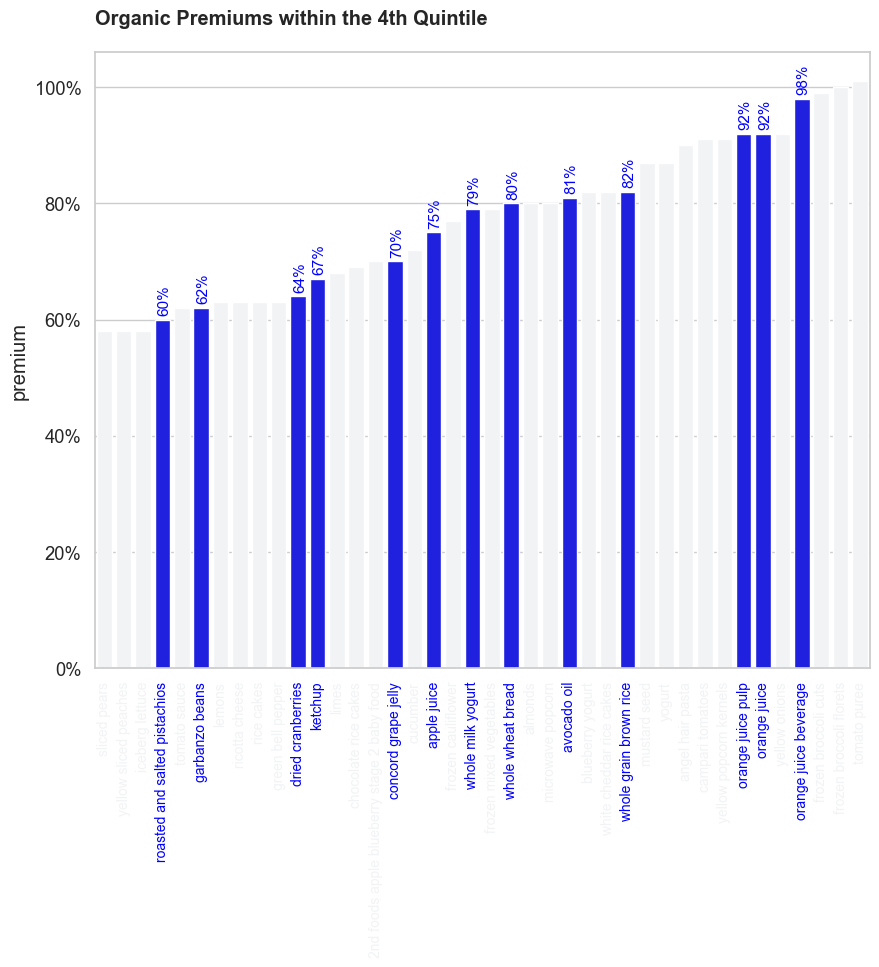

In [19]:

df_barplotq4 = df_compare[df_compare['quintile']==3].sort_values(by='premium_percent').reset_index(drop=True)

fig,ax = plt.subplots(figsize=(10,8))

g = sns.barplot(
    x = 'common_name',
    y = 'premium_percent',
    data = df_barplotq4,
    hue = 'highlight',
    palette = ['#F2F3F5', '#00f'],
    legend = False
    )

# x-axis
# g.xaxis.set_ticklabels([])
g.set(xlabel='')

plt.xticks(rotation='vertical', fontsize = 10, ha='center', va='top')
# change x-axis tick label color based on condition
for tick in g.get_xticklabels():
    if tick.get_text() in ls_valuedriver:
        tick.set_color('#00f')
    else:
        tick.set_color('#F2F3F5')


# y-axis
g.set(ylabel='premium')
# plt.tick_params(
#     bottom=True, 
#     color='black',
#     labelbottom=True, 
#     labelcolor= 'black')
# Add '%' symbols to x-axis labels
def percent_formatter(x, pos):
    return f'{x/100:.0%}'
plt.gca().yaxis.set_major_formatter(FuncFormatter(percent_formatter))

# gridlines

# datalabels
fontsize = 11
ax.annotate(
    f"{'60'}%", 
    xy=(3.1, 60), 
    xytext=(0, 3),  # 3 points offset
    textcoords="offset points", 
    color = '#00f',
    ha="center", va="bottom", fontsize=fontsize, rotation='vertical')

ax.annotate(
    f"{'62'}%", 
    xy=(5.1, 62), 
    xytext=(0, 3),  # 3 points offset
    textcoords="offset points", 
    color = '#00f',
    ha="center", va="bottom", fontsize=fontsize, rotation='vertical')

ax.annotate(
    f"{'64'}%", 
    xy=(10.1, 64), 
    xytext=(0, 3),  # 3 points offset
    textcoords="offset points", 
    color = '#00f',
    ha="center", va="bottom", fontsize=fontsize, rotation='vertical')

ax.annotate(
    f"{'67'}%", 
    xy=(11.1, 67), 
    xytext=(0, 3),  # 3 points offset
    textcoords="offset points", 
    color = '#00f',
    ha="center", va="bottom", fontsize=fontsize, rotation='vertical')

ax.annotate(
    f"{'70'}%", 
    xy=(15.1, 70), 
    xytext=(0, 3),  # 3 points offset
    textcoords="offset points", 
    color = '#00f',
    ha="center", va="bottom", fontsize=fontsize, rotation='vertical')

ax.annotate(
    f"{'75'}%", 
    xy=(17.1, 75), 
    xytext=(0, 3),  # 3 points offset
    textcoords="offset points", 
    color = '#00f',
    ha="center", va="bottom", fontsize=fontsize, rotation='vertical')

ax.annotate(
    f"{'79'}%", 
    xy=(19.1, 79), 
    xytext=(0, 3),  # 3 points offset
    textcoords="offset points", 
    color = '#00f',
    ha="center", va="bottom", fontsize=fontsize, rotation='vertical')

ax.annotate(
    f"{'80'}%", 
    xy=(21.1, 80), 
    xytext=(0, 3),  # 3 points offset
    textcoords="offset points", 
    color = '#00f',
    ha="center", va="bottom", fontsize=fontsize, rotation='vertical')

ax.annotate(
    f"{'81'}%", 
    xy=(24.1, 81), 
    xytext=(0, 3),  # 3 points offset
    textcoords="offset points", 
    color = '#00f',
    ha="center", va="bottom", fontsize=fontsize, rotation='vertical')

ax.annotate(
    f"{'82'}%", 
    xy=(27.1, 82), 
    xytext=(0, 3),  # 3 points offset
    textcoords="offset points", 
    color = '#00f',
    ha="center", va="bottom", fontsize=fontsize, rotation='vertical')

ax.annotate(
    f"{'92'}%", 
    xy=(33.1, 92), 
    xytext=(0, 3),  # 3 points offset
    textcoords="offset points", 
    color = '#00f',
    ha="center", va="bottom", fontsize=fontsize, rotation='vertical')

ax.annotate(
    f"{'92'}%", 
    xy=(34.1, 92), 
    xytext=(0, 3),  # 3 points offset
    textcoords="offset points", 
    color = '#00f',
    ha="center", va="bottom", fontsize=fontsize, rotation='vertical')

ax.annotate(
    f"{'98'}%", 
    xy=(36.1, 98), 
    xytext=(0, 3),  # 3 points offset
    textcoords="offset points", 
    color = '#00f',
    ha="center", va="bottom", fontsize=fontsize, rotation='vertical')

# chart title
g.set_title('Organic Premiums within the 4th Quintile', loc='left', pad=20, fontweight='bold')

# border
fig.show()

## Bar Chart: Premiums by Department

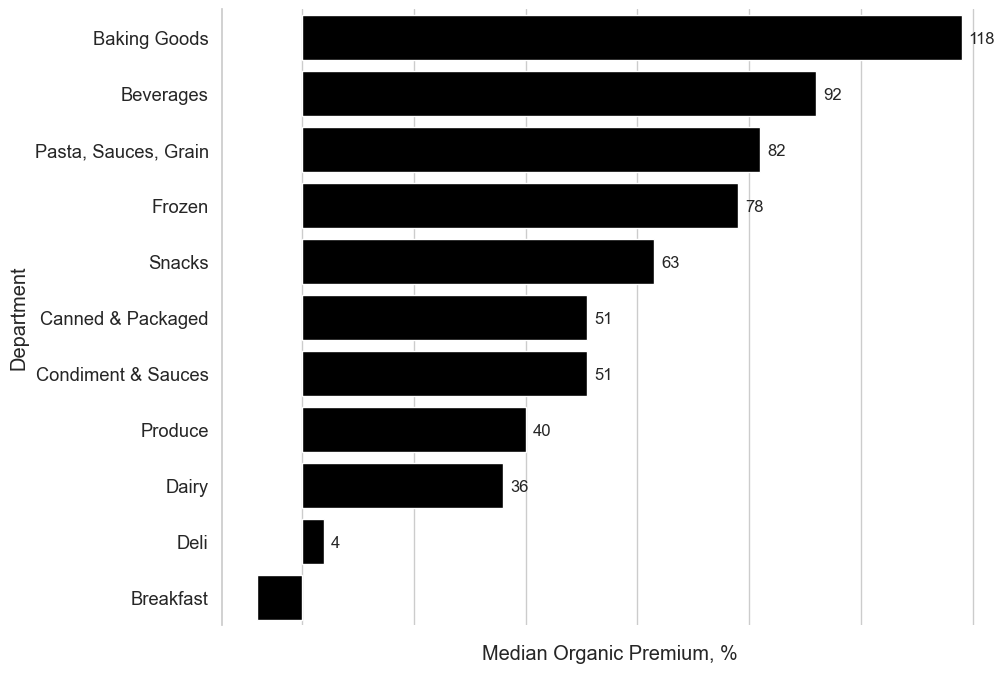

In [20]:
# dataset median by department barplot
df_barplot_dept = df_department_med[df_department_med['department'].isin(ls_significant_departments)]


# create bar chart to show median premiums by category
fig,ax = plt.subplots(figsize=(10,8))

g = sns.barplot(
    x = 'med_premium_percent',
    y = 'department',
    data = df_barplot_dept.sort_values(by = 'med_premium_percent', ascending = False),
    color=sns.color_palette()[0],
    saturation=1.,
)

# add data labels
datalabel_hbar(g)

# remove x-axis tick labels
g.xaxis.set_ticklabels([])

# rename axes labels
g.set(xlabel='Median Organic Premium, %', ylabel='Department')

# remove border
sns.despine(bottom=True);
    

## KDE: Entire Dataset w/ Median Line

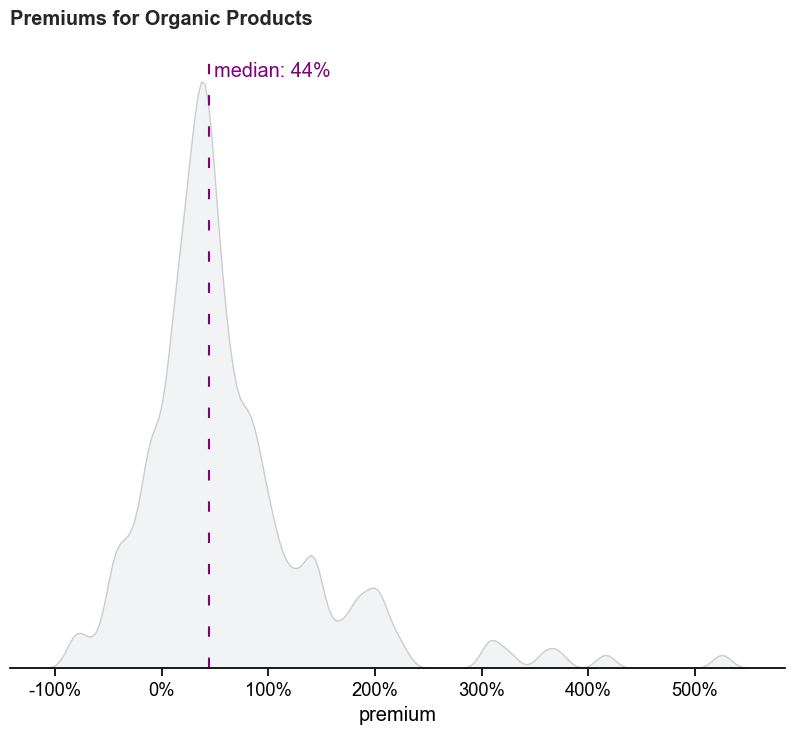

In [21]:
# set overall plot style, font size scaling factor, and color palette
fig,ax = plt.subplots(figsize=(10,8))
sns.set(style="whitegrid", 
        font_scale=1.2, 
        palette=custom_colors 
       )

# create a distribution curve using KDE 
dist = sns.kdeplot(
    data=df_compare,
    x='premium_percent',
    bw_adjust=0.3,
    fill=True,
    color='#F2F3F5', # white gray
    edgecolor='#CCCCCC', # very light gray
    zorder=1,
    alpha=1
    )

# add a dotted line showing the median 
xmedian = 44
plt.axvline(xmedian, 
            c='purple', 
            linestyle=(0, (5, 10)),  # Loosely dashed 
            linewidth=1.5, 
            zorder=2
           )
# data lables
# add data label to median line
plt.text(x = 44+5, # x-coordinate position of data label, adjusted to be 3 right of the data point
         y = 0.0098, # y-coordinate position of data label, to take max height 
         s = f'median: {xmedian}%', # data label
         color = 'purple') # colour of the vertical mean line

# borders
sns.despine(left=True, bottom= False)
ax.spines['bottom'].set_color('black') # Set the color of the x-axis spine explicitly

# gridlines
plt.grid(axis='y', linewidth=0)
plt.grid(axis='x', linewidth=0)

# y-axis 
plt.tick_params(left=False, labelleft=False)
dist.set_ylabel('')

# x-axis
plt.tick_params(
    bottom=True, 
    color='black',
    labelbottom=True, 
    labelcolor= 'black')
# Add '%' symbols to x-axis labels
def percent_formatter(x, pos):
    return f'{x/100:.0%}'
plt.gca().xaxis.set_major_formatter(FuncFormatter(percent_formatter))
plt.xlabel('premium', color='black')

# chart title
dist.set_title('Premiums for Organic Products', loc='left', pad=20, fontweight='bold')

plt.show()


## Boxplot: Premiums by Department

/var/folders/kk/vvsk9nv52tx96gkssmn_4c240000gn/T/ipykernel_69502/3128555073.py:18: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


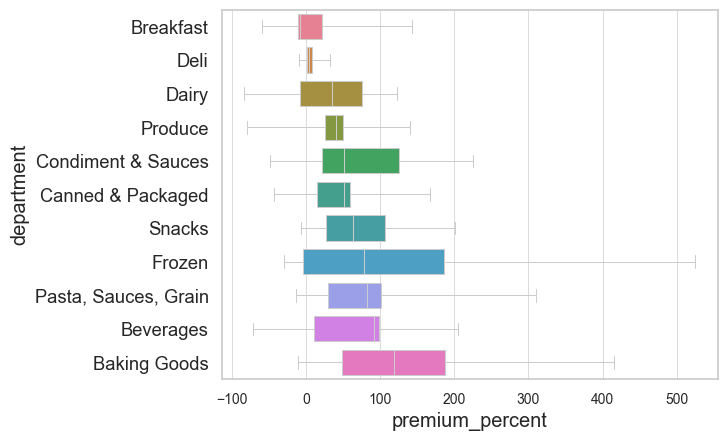

In [22]:
# create a boxplot reflecting organic premiums by department


boxplot = sns.boxplot(
    y = 'department',
    x = 'premium_percent',
    data = df_compare[df_compare['department'].isin(ls_significant_departments)].sort_values(by = 'dept_median'),
    hue = 'department',
    whis=(0, 100),
    width = 0.75, 
    fill = True,
    linecolor = '#CCCCCC',
    linewidth = 0.75
    )

plt.xticks( fontsize = 10)

fig.show()

# gridlines
plt.grid(axis='y', linewidth=0)
plt.grid(axis='x', linewidth=0.5)

## Comboplot: Distribution and Premiums by Department

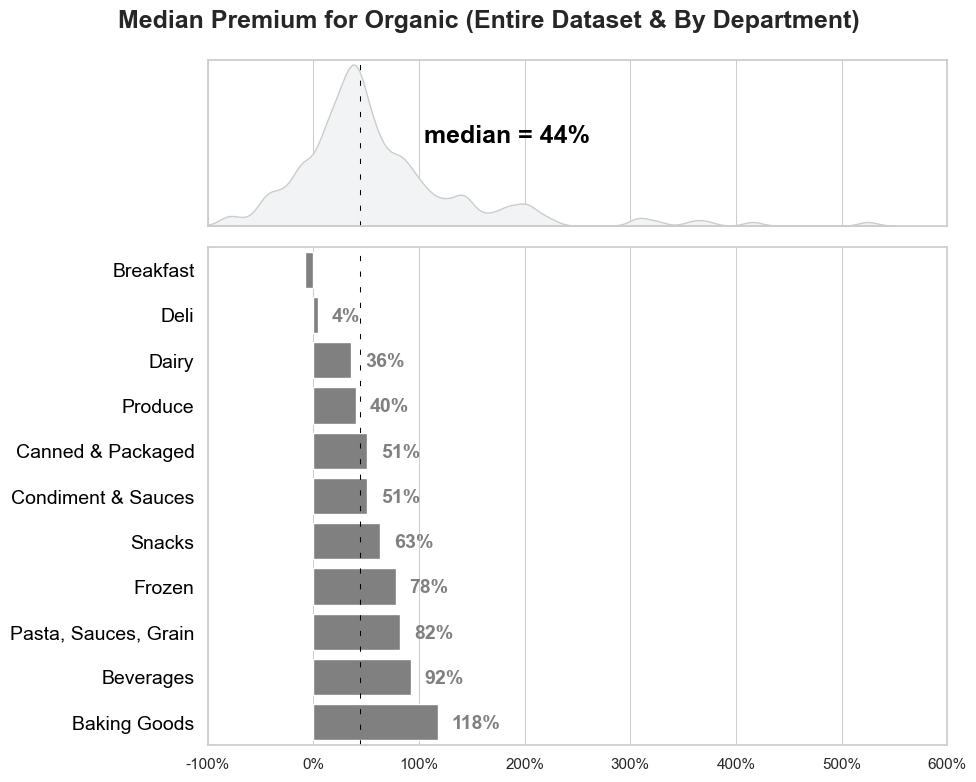

In [72]:

f, axs = plt.subplots(2, 1, figsize=(10, 8), gridspec_kw=dict(height_ratios=[1,3]))

# create a distribution curve using KDE 
sns.kdeplot(
    data=df_compare,
    x='premium_percent',
    bw_adjust=0.3,
    fill=True,
    color='#F2F3F5', # white gray
    edgecolor='#CCCCCC', # very light gray
    zorder=1,
    alpha=1,
    ax=axs[0]
    )

# add a dotted line showing the median 
xmedian = 44
axs[0].axvline(x=xmedian,
               c='black',
               linestyle=(0, (5, 10)),  # Loosely dashed 
               linewidth=0.75,
               zorder=2,
               )

xmedian = 44
axs[1].axvline(x=xmedian,
               c='black',
               linestyle=(0, (5, 10)),  # Loosely dashed 
               linewidth=0.75,
               zorder=2,
               )

axs[0].text(x = 105, # x-coordinate position of data label, adjusted to be 3 right of the data point
    y = 0.005, # y-coordinate position of data label, to take max height 
    s = f'median = {xmedian}%', # data label
    fontsize = 18,
    fontweight = 'bold',
    color = 'black') # colour of the vertical mean line

df_barplot_med = df_department_med[df_department_med['department'].isin(ls_significant_departments)].sort_values(by='med_premium_percent')

sns.barplot(
    x = 'med_premium_percent',
    y = 'department',
    data = df_barplot_med,
    color = 'gray',
    ax=axs[1]
    )
# data labels
# add labels to a horizontal bar chart
def datalabel_hbar(ax, fontsize=12):
  rects = [rect for rect in ax.get_children() if isinstance(rect, mpl.patches.Rectangle)]
  
  for rect in rects:
    width = rect.get_width()
    if width > 1:
      ax.annotate(f"{width:.0f}%", xy=(width, rect.get_y() + rect.get_height() / 2),
        xytext=(10,-1), # 5 points offset
         textcoords="offset points", ha="left", va="center", 
        fontsize=fontsize, fontweight='bold', color = 'gray')
        
datalabel_hbar(axs[1], 14)

# y-axis
axs[0].tick_params(left=False, labelleft=False)
axs[1].tick_params(axis='y', labelsize=14, labelcolor = 'black')
axs[0].set_ylabel('')
axs[1].set_ylabel('')
axs[0].set_ylim(0, 0.01)

# x-axis
axs[0].tick_params(bottom=False, labelbottom=False)
axs[0].set_xlabel('')
axs[0].set_xlim(-100,600)
axs[1].set_xlim(-100,600)
# Add '%' symbols to x-axis labels and set x-axis label for axs[1]
axs[1].xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{x/100:.0%}'))
axs[1].set_xlabel('', color='black')
axs[1].tick_params(axis='x', labelsize=11)


# borders
# sns.despine(ax=axs[0], left=True, bottom=False)
# sns.despine(ax=axs[1], left=True)

# gridlines
axs[0].grid(axis='y', linewidth=0)
axs[1].grid(axis='x', linewidth=0.75)
axs[0].grid(axis='x', linewidth=0.75)

# title
# axs[0].set_title('Median Premium for Organic (Entire Dataset)', loc='left', pad=20, fontweight='bold', fontsize=18)
# axs[1].set_title('Median Premium for Organic by Department', loc='left', pad=20, fontweight='bold', fontsize=18)
plt.suptitle('Median Premium for Organic (Entire Dataset & By Department)', ha = 'center', fontsize = 18, fontweight='bold')


f.tight_layout()

## Bar Chart: Premiums by Department

/var/folders/kk/vvsk9nv52tx96gkssmn_4c240000gn/T/ipykernel_69502/2881918729.py:31: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


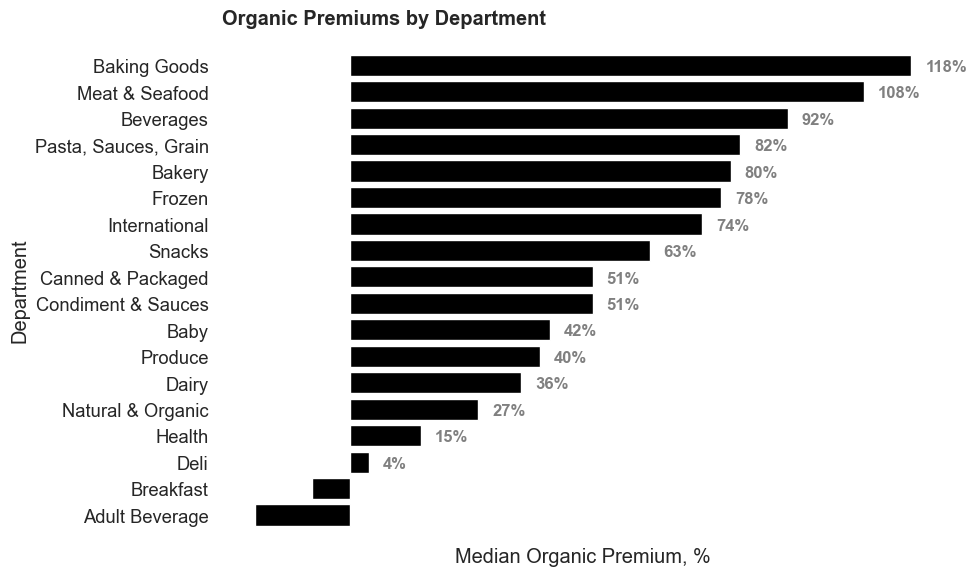

In [24]:
# create bar chart to show median premiums by category

# fig size & layout
plt.figure(figsize=(10,6), tight_layout=True)
g = sns.barplot(
    x = 'med_premium_percent',
    y = 'department',
    data = df_department_med.sort_values(by = 'med_premium_percent', ascending = False),
    saturation=1,
)

# add data labels
datalabel_hbar(g)

# set ticks and tick labels
g.xaxis.set_ticklabels([])

# set axis labels
g.set(xlabel='Median Organic Premium, %', ylabel='Department')

# remove gridlines
plt.grid(axis='y', linewidth=0)
plt.grid(axis='x', linewidth=0)

# remove border
sns.despine(bottom=True, left=True)

# Add chart title
g.set_title('Organic Premiums by Department', loc='left', pad=20, fontweight='bold')

fig.show()
    

## Scatter Plot: Premium by Department

/var/folders/kk/vvsk9nv52tx96gkssmn_4c240000gn/T/ipykernel_69502/2349500598.py:34: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


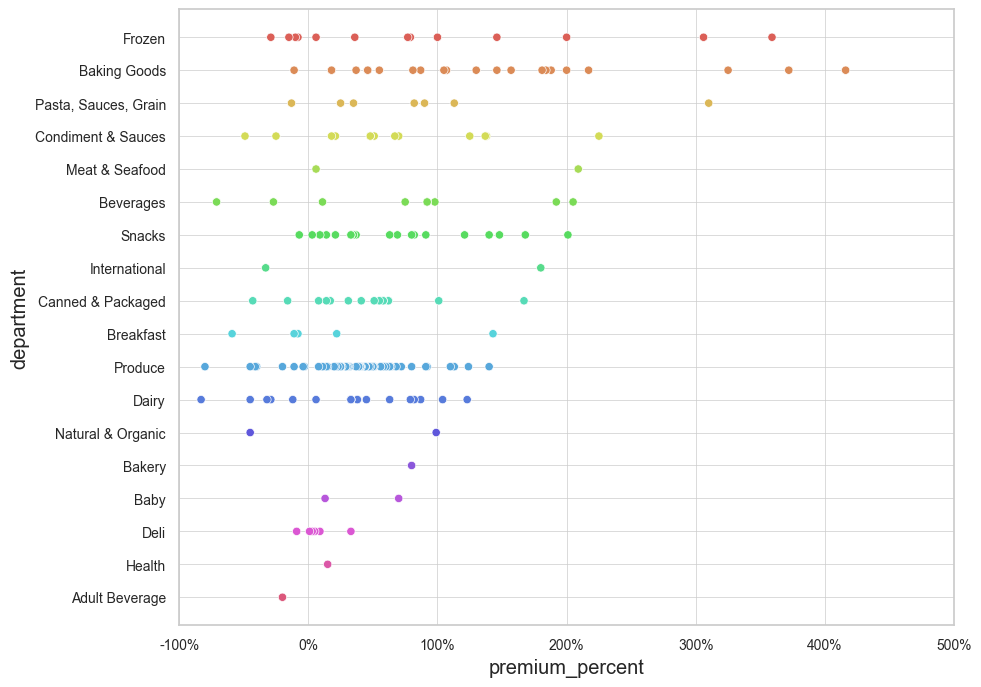

In [25]:
fig,ax = plt.subplots(figsize=(10,8))
# plt.figure(figsize=(10,8), tight_layout=True)


# Create a scatter plot
g = sns.scatterplot(
    # data = df_compare[df_compare['quintile'] == 3 ].sort_values(by='premium_percent', ascending = False),
    data = df_compare.sort_values(by='premium_percent', ascending = False),
    x = 'premium_percent',
    y = 'department',
    hue = 'department',
    palette='hls',
    legend=False
    )
    
# x-axis
ax.set_xlim(-100, 500)
plt.xticks(fontsize=10)

# Add '%' symbols to x-axis labels
def percent_formatter(x, pos):
    return f'{x/100:.0%}'

plt.gca().xaxis.set_major_formatter(FuncFormatter(percent_formatter))


# y-axis
plt.yticks(fontsize=10)

# gridlines
plt.grid(axis='y', linewidth=0.5)
plt.grid(axis='x', linewidth=0.5)

fig.show()

## Horizontal Barplot: Premiums for Complex Items

In [26]:
df_test = df_compare[df_compare['quintile'] == 4].sort_values(by = 'premium_percent', ascending = False)
df_test = df_test[['common_name', 'premium_percent', 'highlight', 'net_fill_comp_percent']]

df_test[df_test.net_fill_comp_percent > 60]



,common_name,premium_percent,highlight,net_fill_comp_percent
154,smoked paprika,416.0,no_highlight,81.0
70,frozen peas and carrots,359.0,complexity,83.0
16,black pepper,325.0,no_highlight,75.0
197,yellow mustard,225.0,no_highlight,86.0
189,whole chicken,209.0,complexity,100.0
131,raspberry lemonade,205.0,complexity,62.0
38,chocolate chip cookies,201.0,complexity,100.0
71,frozen pizza,200.0,complexity,116.0
120,paprika,188.0,no_highlight,111.0
50,cumin,146.0,no_highlight,84.0


/var/folders/kk/vvsk9nv52tx96gkssmn_4c240000gn/T/ipykernel_69502/3699396450.py:47: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


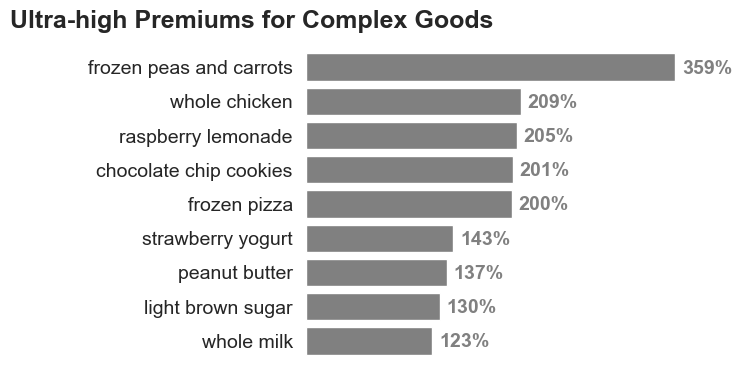

In [58]:

df_complex = df_compare[df_compare.highlight == 'complexity'].sort_values(by='premium_percent', ascending = False)

fig,ax = plt.subplots(figsize=(5,4))

g = sns.barplot(
    x = 'premium_percent',
    y = 'common_name',
    data = df_complex,
    color = 'gray',
    legend = False
)

# add data labels
# add labels to a horizontal bar chart
def datalabel_hbar(ax, fontsize=8):
  rects = [rect for rect in ax.get_children() if isinstance(rect, mpl.patches.Rectangle)]
  
  for rect in rects:
    width = rect.get_width()
    if width > 1:
      ax.annotate(f"{width:.0f}%", xy=(width, rect.get_y() + rect.get_height() / 2),
        xytext=(5,-1), # 5 points offset
         textcoords="offset points", ha="left", va="center", 
        color = 'gray', fontsize=fontsize, fontweight = 'bold')
        
datalabel_hbar(g, 14)

# set ticks and tick labels
g.xaxis.set_ticklabels([])
plt.yticks(fontsize=14)


# set axis labels
g.set(xlabel='', ylabel='')

# remove gridlines
plt.grid(axis='y', linewidth=0)
plt.grid(axis='x', linewidth=0)

# remove border
sns.despine(bottom=True, left=True)

# Add chart title
plt.suptitle('Ultra-high Premiums for Complex Goods', fontsize = 18, ha = 'right', fontweight='bold')

fig.show()

## Horizontal Barplot: Premiums for Oranic Staple Goods

/var/folders/kk/vvsk9nv52tx96gkssmn_4c240000gn/T/ipykernel_69502/3312822233.py:47: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


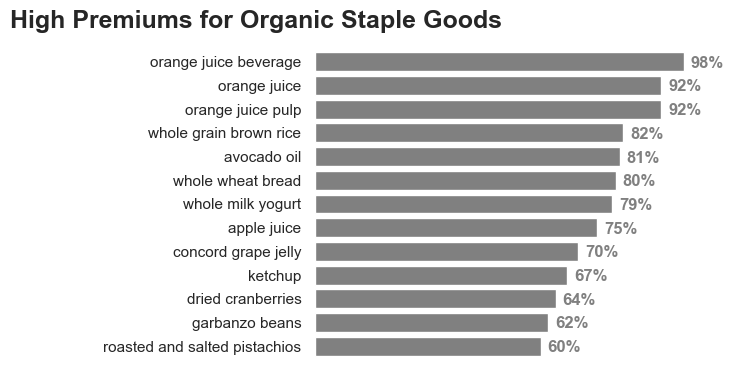

In [73]:
df_value = df_compare[df_compare.highlight == 'value'].sort_values(by='premium_percent', ascending = False)

fig,ax = plt.subplots(figsize=(5,4))

g = sns.barplot(
    x = 'premium_percent',
    y = 'common_name',
    data = df_value,
    color = 'gray',
    legend = False
)

# add data labels
# add labels to a horizontal bar chart
def datalabel_hbar(ax, fontsize=8):
  rects = [rect for rect in ax.get_children() if isinstance(rect, mpl.patches.Rectangle)]
  
  for rect in rects:
    width = rect.get_width()
    if width > 1:
      ax.annotate(f"{width:.0f}%", xy=(width, rect.get_y() + rect.get_height() / 2),
        xytext=(5,-1), # 5 points offset
         textcoords="offset points", ha="left", va="center", 
        color = 'gray', fontsize=fontsize, fontweight = 'bold')
        
datalabel_hbar(g, 12)

# set ticks and tick labels
g.xaxis.set_ticklabels([])
plt.yticks(fontsize=11)


# set axis labels
g.set(xlabel='', ylabel='')

# remove gridlines
plt.grid(axis='y', linewidth=0)
plt.grid(axis='x', linewidth=0)

# remove border
sns.despine(bottom=True, left=True)

# Add chart title
# g.set_title('High Premiums for Organic Staple Goods', loc='left', pad=20, fontweight='bold', fontsize = 18)
plt.suptitle('High Premiums for Organic Staple Goods', fontsize = 18, ha = 'right', fontweight='bold')

fig.show()